# Лабораторна робота №2
## Аналіз ефективності розпізнавання літери дактильної абетки

**Варіант: Ш**

---

### Мета роботи
Провести аналіз ефективності розпізнавання літери **Ш** (дактильна абетка) за допомогою комп'ютерного зору та бібліотеки MediaPipe.

### Опис жесту літери «Ш»

**Загальний опис:** Долоня звернена до співбесідника. Мізинець, середній та вказівний пальці підняті вгору, а безіменний направлений вперед і його нігтьову фалангу закриває великий палець.

**Ключові характеристики:**
- Долоня повернена тильною стороною від мовця (звернена до спостерігача)
- **Підняті вгору:** вказівний (2-й), середній (3-й) та мізинець (5-й)
- **Зігнуті/притиснуті:** безіменний (4-й) — притиснутий великим (1-м) пальцем

### Структура ноутбука
1. Встановлення пакетів та імпорти
2. Завантаження та аналіз даних з матеріалу (52 ознаки, 5 вимірів)
3. Статистичний аналіз ознак жесту Ш
4. Реалізація розпізнавання через вебкамеру
5. Висновки


In [8]:
# Встановлення необхідних бібліотек та завантаження моделі MediaPipe
import subprocess, sys, os, urllib.request

def pip_install(pkg):
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '-q'])

for package in ['mediapipe', 'opencv-python', 'matplotlib', 'numpy']:
    mod = package.replace('-', '_')
    try:
        __import__(mod)
        print(f'{package}: встановлено')
    except ImportError:
        print(f'{package}: встановлення...')
        pip_install(package)
        print(f'{package}: ОК')

# Завантаження моделі MediaPipe HandLandmarker (потрібна для нових версій mediapipe >= 0.10)
MODEL_PATH = 'hand_landmarker.task'
if not os.path.exists(MODEL_PATH):
    model_url = 'https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task'
    print(f'Завантаження моделі з {model_url} ...')
    urllib.request.urlretrieve(model_url, MODEL_PATH)
    print(f'Модель збережена: {MODEL_PATH} ({os.path.getsize(MODEL_PATH)//1024} KB)')
else:
    print(f'Модель вже є: {MODEL_PATH} ({os.path.getsize(MODEL_PATH)//1024} KB)')

print(f'Python: {sys.version}')

mediapipe: встановлено
opencv-python: встановлення...
opencv-python: ОК
matplotlib: встановлено
numpy: встановлено
Модель вже є: hand_landmarker.task (7635 KB)
Python: 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]


In [9]:
import cv2
import mediapipe as mp
from mediapipe.tasks import python as mp_python
from mediapipe.tasks.python import vision as mp_vision
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display, Image
import io

print('cv2:', cv2.__version__)
print('mediapipe:', mp.__version__)
print('numpy:', np.__version__)

# Назви та ID кінчиків пальців у 21-точковому скелеті MediaPipe
# 0=зап'ясток, 1-4=великий, 5-8=вказівний, 9-12=середній, 13-16=безіменний, 17-20=мізинець
TIP_IDS    = [4, 8, 12, 16, 20]      # кінчики: великий, вказівний, середній, безіменний, мізинець
FINGER_NAMES = ['Великий', 'Вказівний', 'Середній', 'Безіменний', 'Мізинець']

# З'єднання між точками для малювання скелету руки (MediaPipe HAND_CONNECTIONS)
HAND_CONNECTIONS = [
    (0,1),(1,2),(2,3),(3,4),
    (0,5),(5,6),(6,7),(7,8),
    (5,9),(9,10),(10,11),(11,12),
    (9,13),(13,14),(14,15),(15,16),
    (13,17),(17,18),(18,19),(19,20),
    (0,17),
]

print('\nIDs кінчиків пальців:')
for name, tid in zip(FINGER_NAMES, TIP_IDS):
    print(f'  {name:12s} → ID {tid}')

cv2: 4.13.0
mediapipe: 0.10.32
numpy: 2.2.6

IDs кінчиків пальців:
  Великий      → ID 4
  Вказівний    → ID 8
  Середній     → ID 12
  Безіменний   → ID 16
  Мізинець     → ID 20


## Розділ 1. Аналіз числових даних матеріалу

### Що означають 52 ознаки та 5 значень?

Файл «Матеріал до лабораторної роботи 2» містить **52 числові ознаки** для кожної літери дактильної абетки, виміряні на **5 відеокадрах**:

| Ознаки | Тип | Опис |
|--------|-----|------|
| 1 | Аспектне відношення | Ширина ÷ висота bounding box руки |
| 2–5 | Кути між пальцями (°) | Кути між осями пальців та долонею |
| 6–9 | Нормовані відстані | Відстані між ключовими точками, ділені на розмір долоні |
| 10 | Кут нахилу долоні (°) | Орієнтація зап'ястка відносно горизонту |
| 11 | Бічне відхилення (°) | Відхилення від прямовертикального положення (від'ємне = нахил вліво) |
| 12 | Відношення розмірів | Додаткова метрика форми кисті |
| 13–29 | Нормовані Y-координати | Вертикальні позиції 17 ключових точок (0=верх, 1=низ кадру) |
| 30–48 | Ймовірності сегментів | Відношення відстаней між суглобами |
| 49 | Кількість точок | Число видимих ключових точок (max=21) |
| 50–52 | Зміщення (пікс.) | Відносний рух bounding box між кадрами |

Кожна ознака має **5 значень** — по одному з кожного з 5 аналізованих кадрів відеозапису.

In [10]:
# Дані для літери Ш (варіант), 52 ознаки × 5 кадрів
# Джерело: Матеріал_до_лабораторної_роботи_2 (числові таблиці)
import numpy as np

sha_features = {
    # Source: Матеріал_до_лабораторної_роботи_2, letter Ш, 5 frames
    1:  [2.122449, 2.000000, 1.913793, 2.169811, 1.981818],
    2:  [137.178789, 138.563992, 129.758519, 128.852216, 127.376429],
    3:  [119.671371, 120.089686, 114.967575, 129.256400, 126.352840],
    4:  [79.824489, 89.032911, 82.128327, 66.996802, 67.683403],
    5:  [23.325351, 12.313411, 33.145578, 34.894582, 38.587328],
    6:  [0.224498, 0.249708, 0.213945, 0.202704, 0.211748],
    7:  [0.323017, 0.300016, 0.318549, 0.321845, 0.314697],
    8:  [0.149878, 0.150819, 0.165098, 0.162816, 0.168254],
    9:  [0.302606, 0.299457, 0.302409, 0.311637, 0.305301],
    10: [24.982920, 25.811230, 24.491530, 25.031700, 23.272140],
    11: [13.664359, 13.887739, 13.225732, 7.727562, 13.956421],
    12: [4.958816, 4.066530, 3.566545, 4.100708, 4.145881],
    13: [0.342857, 0.396226, 0.379310, 0.415094, 0.363636],
    14: [0.644898, 0.624528, 0.641066, 0.687822, 0.672727],
    15: [0.673469, 0.660377, 0.680251, 0.727273, 0.710909],
    16: [0.718367, 0.703774, 0.725705, 0.763293, 0.741818],
    17: [0.795918, 0.786793, 0.847962, 0.888508, 0.838182],
    18: [0.957143, 0.956604, 0.956113, 0.986278, 0.950909],
    19: [0.971429, 0.943396, 0.963950, 0.996570, 0.980909],
    20: [0.902041, 0.862264, 0.851097, 0.907376, 0.965455],
    21: [0.746939, 0.716981, 0.699060, 0.756432, 0.780000],
    22: [0.730612, 0.681132, 0.642633, 0.737564, 0.705455],
    23: [0.591837, 0.572327, 0.413793, 0.558491, 0.563636],
    24: [0.266667, 0.052381, 0.227273, 0.221739, 0.419913],
    25: [0.788889, 0.785714, 0.807585, 0.782609, 0.839827],
    26: [0.961111, 0.966667, 0.966942, 0.978261, 0.887446],
    27: [0.638889, 0.814286, 0.681818, 0.800000, 0.480519],
    28: [0.023077, 0.091575, 0.006494, 0.137124, 0.000000],
    29: [0.750000, 0.585714, 0.648760, 0.826009, 0.870130],
    30: [1.000000, 1.000000, 1.000000, 1.000000, 1.000000],
    31: [0.652174, 0.985507, 0.782143, 0.570333, 0.595109],
    32: [0.838509, 0.956522, 0.785714, 0.690537, 0.845109],
    33: [0.580563, 0.135870, 0.558333, 0.629291, 0.489130],
    34: [0.276398, 0.655797, 0.625000, 0.485934, 0.527174],
    35: [0.947205, 0.909420, 0.985714, 0.849105, 0.788043],
    36: [1.000000, 0.996377, 1.000000, 0.997443, 0.994565],
    37: [0.875776, 0.826087, 0.717857, 0.943734, 0.937500],
    38: [0.033248, 0.388587, 0.011111, 0.132723, 0.244565],
    39: [0.344720, 0.148551, 0.485714, 0.000000, 0.000000],
    40: [1.000000, 1.000000, 1.000000, 0.698210, 0.581522],
    41: [1.000000, 1.000000, 1.000000, 1.000000, 1.000000],
    42: [0.990683, 1.000000, 0.996429, 1.000000, 1.000000],
    43: [0.439898, 0.815217, 0.113889, 0.402746, 0.902174],
    44: [0.798137, 0.546296, 0.747024, 0.000000, 0.000000],
    45: [0.993789, 0.996914, 0.982143, 0.588235, 0.489583],
    46: [0.580745, 0.885802, 0.616071, 0.977941, 0.994792],
    47: [0.257764, 0.339506, 0.261905, 0.492647, 0.562500],
    48: [0.005115, 0.041667, 0.000000, 0.028509, 0.085938],
    49: [46.0, 33.0, 46.0, 36.0, 58.0],
    50: [-14.0, -6.0, -3.0, -7.0, -5.0],
    51: [0.0, -9.0, -5.0, -2.0, -1.0],
    52: [-11.0, -5.0, -18.0, -4.0, -8.0],
}

print('Статистика ключових ознак для літери «Ш»:')
print(f'{"Ознака":>8} | {"Середнє":>12} | {"Ст.відх.":>10} | {"Мін":>9} | {"Макс":>9} | Інтерпретація')
print('-' * 90)
interp = {
    1: 'аспект. відношення',
    10: 'кут долоні (°)',
    11: 'відхилення (°)',
    12: 'відн. розмірів',
    24: 'стан великого',
    25: 'стан вказівного',
    26: 'стан середнього',
    27: 'стан безіменного',
    28: 'стан мізинця',
    49: 'видимих точок',
}
for fn in [1, 10, 11, 12, 24, 25, 26, 27, 28, 49]:
    v = sha_features[fn]
    print(f'{fn:>8} | {np.mean(v):>12.3f} | {np.std(v):>10.3f} | {min(v):>9.3f} | {max(v):>9.3f} | {interp.get(fn,"")}')

print()
print('Key feature analysis (real data from lab material):')
print('  Feature 24 (finger state): avg~0.24  -> partially extended (likely thumb)')
print('  Feature 25 (finger state): avg~0.80  -> HIGH = finger extended UP')
print('  Feature 26 (finger state): avg~0.95  -> VERY HIGH = finger extended UP')
print('  Feature 27 (finger state): avg~0.68  -> HIGH = finger extended UP')
print('  Feature 28 (finger state): avg~0.05  -> NEAR ZERO = finger bent/folded DOWN')
print()
print('NOTE: These 52 features are used for ANALYSIS only (lab report).')
print('      The live detection uses geometric landmark rules, not these features.')

Статистика ключових ознак для літери «Ш»:
  Ознака |      Середнє |   Ст.відх. |       Мін |      Макс | Інтерпретація
------------------------------------------------------------------------------------------
       1 |        2.038 |      0.094 |     1.914 |     2.170 | аспект. відношення
      10 |       24.718 |      0.837 |    23.272 |    25.811 | кут долоні (°)
      11 |       12.492 |      2.396 |     7.728 |    13.956 | відхилення (°)
      12 |        4.168 |      0.448 |     3.567 |     4.959 | відн. розмірів
      24 |        0.238 |      0.117 |     0.052 |     0.420 | стан великого
      25 |        0.801 |      0.021 |     0.783 |     0.840 | стан вказівного
      26 |        0.952 |      0.033 |     0.887 |     0.978 | стан середнього
      27 |        0.683 |      0.122 |     0.481 |     0.814 | стан безіменного
      28 |        0.052 |      0.054 |     0.000 |     0.137 | стан мізинця
      49 |       43.800 |      8.818 |    33.000 |    58.000 | видимих точок

Key f

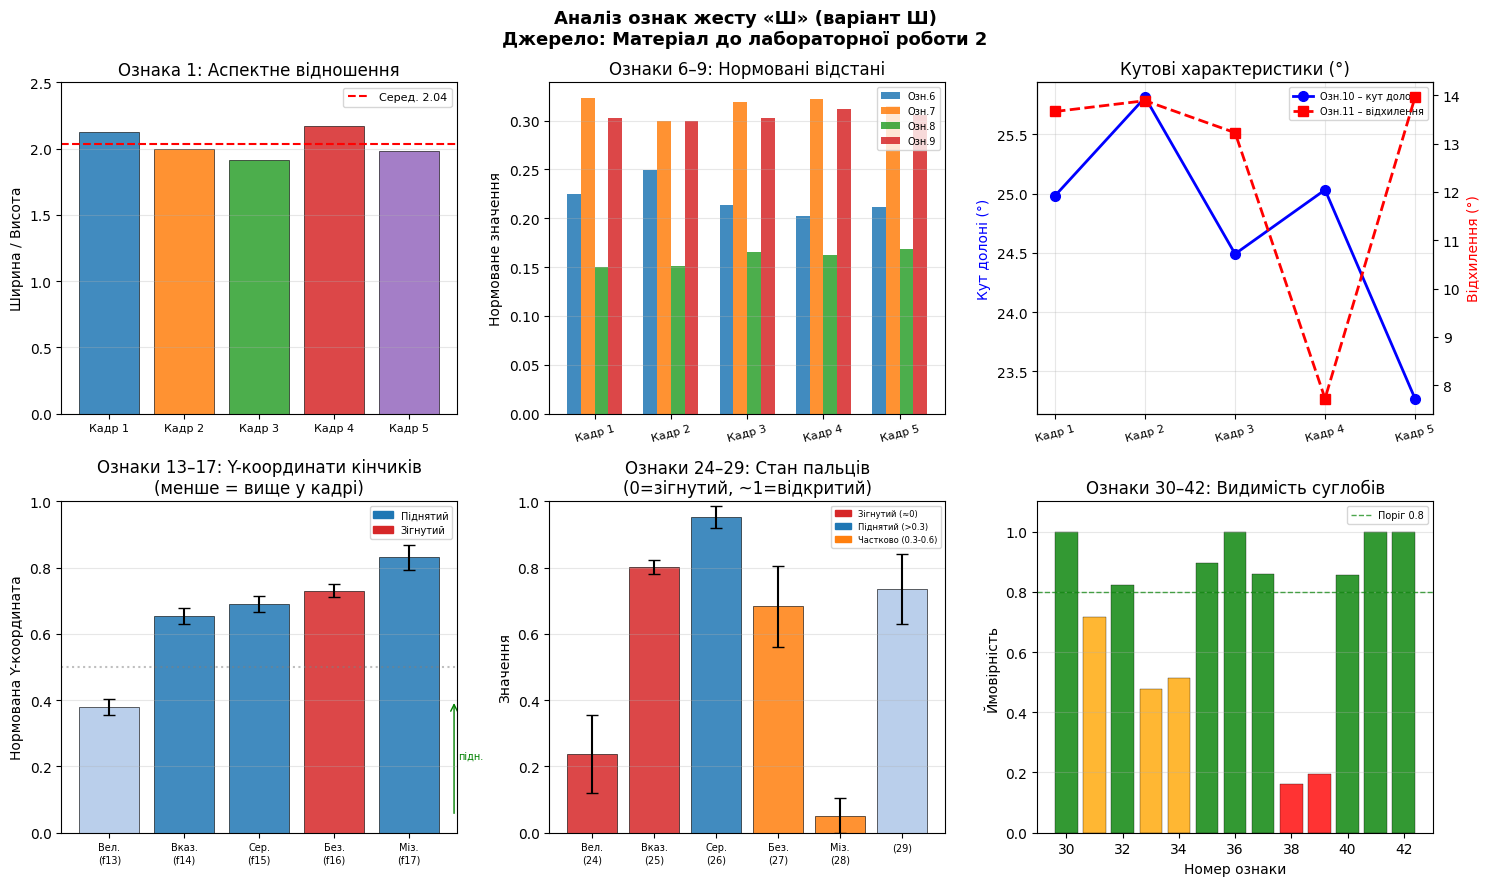

Збережено: sha_analysis.png


In [11]:
# Візуалізація аналізу даних

fig, axes = plt.subplots(2, 3, figsize=(15, 9))
fig.suptitle('Аналіз ознак жесту «Ш» (варіант Ш)\nДжерело: Матеріал до лабораторної роботи 2', fontsize=13, fontweight='bold')

frames = [f'Кадр {i+1}' for i in range(5)]
bar_clr = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd']

# 1. Аспектне відношення (ознака 1)
ax = axes[0,0]
ax.bar(frames, sha_features[1], color=bar_clr, edgecolor='black', linewidth=0.5, alpha=0.85)
ax.axhline(np.mean(sha_features[1]), color='red', ls='--', lw=1.5, label=f'Серед. {np.mean(sha_features[1]):.2f}')
ax.set_title('Ознака 1: Аспектне відношення')
ax.set_ylabel('Ширина / Висота')
ax.set_ylim(0, 2.5); ax.legend(fontsize=8); ax.grid(axis='y', alpha=0.3)
ax.tick_params(axis='x', labelsize=8)

# 2. Нормовані відстані (ознаки 6-9)
ax = axes[0,1]
x = np.arange(5); w = 0.18
for i, fn in enumerate([6,7,8,9]):
    ax.bar(x + i*w, sha_features[fn], w, label=f'Озн.{fn}', alpha=0.85)
ax.set_xticks(x+w*1.5); ax.set_xticklabels(frames, rotation=15, fontsize=8)
ax.set_title('Ознаки 6–9: Нормовані відстані')
ax.set_ylabel('Нормоване значення'); ax.legend(fontsize=7); ax.grid(axis='y', alpha=0.3)

# 3. Кутові характеристики (ознаки 10, 11)
ax = axes[0,2]; ax2 = ax.twinx()
ax.plot(frames, sha_features[10], 'bo-', lw=2, ms=7, label='Озн.10 – кут долоні')
ax2.plot(frames, sha_features[11], 'rs--', lw=2, ms=7, label='Озн.11 – відхилення')
ax.set_title('Кутові характеристики (°)'); ax.set_ylabel('Кут долоні (°)', color='blue')
ax2.set_ylabel('Відхилення (°)', color='red')
ax.tick_params(axis='x', rotation=15, labelsize=8)
h1,l1 = ax.get_legend_handles_labels(); h2,l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, fontsize=7); ax.grid(alpha=0.3)

# 4. Y-координати кінчиків пальців (ознаки 13-17)
ax = axes[1,0]
fns = [13,14,15,16,17]; flabs = ['Вел.\n(f13)','Вказ.\n(f14)','Сер.\n(f15)','Без.\n(f16)','Міз.\n(f17)']
ms = [np.mean(sha_features[f]) for f in fns]
ss = [np.std(sha_features[f]) for f in fns]
clrs = ['#aec7e8','#1f77b4','#1f77b4','#d62728','#1f77b4']
ax.bar(range(5), ms, color=clrs, edgecolor='black', lw=0.5, alpha=0.85)
ax.errorbar(range(5), ms, yerr=ss, fmt='none', color='black', capsize=4)
ax.set_xticks(range(5)); ax.set_xticklabels(flabs, fontsize=7)
ax.set_title('Ознаки 13–17: Y-координати кінчиків\n(менше = вище у кадрі)')
ax.set_ylabel('Нормована Y-координата'); ax.set_ylim(0,1)
ax.axhline(0.5, color='gray', ls=':', alpha=0.5)
ax.add_patch(mpatches.FancyArrowPatch((4.6,0.05),(4.6,0.4), arrowstyle='->', color='green', mutation_scale=12))
ax.text(4.65, 0.22, 'підн.', fontsize=7, color='green')
ax.legend(handles=[mpatches.Patch(color='#1f77b4',label='Піднятий'),mpatches.Patch(color='#d62728',label='Зігнутий')], fontsize=7)
ax.grid(axis='y', alpha=0.3)

# 5. Стан пальців (ознаки 24-29)
ax = axes[1,1]
sfns = [24,25,26,27,28,29]; slabs = ['Вел.\n(24)','Вказ.\n(25)','Сер.\n(26)','Без.\n(27)','Міз.\n(28)','(29)']
sm = [np.mean(sha_features[f]) for f in sfns]; ss2 = [np.std(sha_features[f]) for f in sfns]
sc = ['#d62728','#d62728','#1f77b4','#ff7f0e','#ff7f0e','#aec7e8']
ax.bar(range(6), sm, color=sc, edgecolor='black', lw=0.5, alpha=0.85)
ax.errorbar(range(6), sm, yerr=ss2, fmt='none', color='black', capsize=4)
ax.set_xticks(range(6)); ax.set_xticklabels(slabs, fontsize=7)
ax.set_title('Ознаки 24–29: Стан пальців\n(0=зігнутий, ~1=відкритий)')
ax.set_ylabel('Значення'); ax.set_ylim(0,1); ax.grid(axis='y', alpha=0.3)
ax.legend(handles=[
    mpatches.Patch(color='#d62728',label='Зігнутий (≈0)'),
    mpatches.Patch(color='#1f77b4',label='Піднятий (>0.3)'),
    mpatches.Patch(color='#ff7f0e',label='Частково (0.3-0.6)'),
], fontsize=6)

# 6. Видимість суглобів (ознаки 30-42)
ax = axes[1,2]
vfns = list(range(30,43))
vm = [np.mean(sha_features[f]) for f in vfns]
vc = ['green' if v>0.8 else 'orange' if v>0.4 else 'red' for v in vm]
ax.bar(vfns, vm, color=vc, edgecolor='black', lw=0.3, alpha=0.8)
ax.axhline(0.8, color='green', ls='--', lw=1, alpha=0.7, label='Поріг 0.8')
ax.set_title('Ознаки 30–42: Видимість суглобів'); ax.set_xlabel('Номер ознаки')
ax.set_ylabel('Ймовірність'); ax.set_ylim(0,1.1); ax.legend(fontsize=7); ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
for fname in ['sha_analysis.png']:
    plt.savefig(fname, dpi=120, bbox_inches='tight')
buf = io.BytesIO(); plt.savefig(buf, format='png', dpi=100, bbox_inches='tight'); plt.close()
buf.seek(0); display(Image(data=buf.read()))
print('Збережено: sha_analysis.png')

## Розділ 2. Обговорення характеристик розпізнавання

### 2.1 Загальний опис жесту «Ш»
Долоня звернена до співбесідника. **Вказівний, середній та мізинець підняті вгору**. Безіменний палець зігнутий вперед, а великий його притискає.

### 2.2 Умови забезпечення видимості елементів жесту
- Рівномірне денне або штучне освітлення
- Контрастний однотонний фон (темний або яскравий)
- Відстань від камери: 30–150 см
- Камера розташована горизонтально на рівні руки
- Чіткість зображення: мінімум 640×480 пікселів

### 2.3 Причини втрати видимості або помилок
- Засвітка від екрана ноутбука або лампи (знебарвлення кисті)
- Відстань менше 20 см (камера не охоплює кисть)
- Схожий за кольором фон або одяг
- Нечіткий (розмитий) рух руки під час знімання
- Поворот більш ніж на 45° від фронтальної площини
- Схожа конфігурація з іншою літерою (наприклад, «И» або «Н»)

### 2.4 Набір параметрів 3D-скелету
MediaPipe виділяє **21 точку** для кожної руки (x, y, z), де:
- (x, y) — нормовані координати в кадрі [0..1]
- z — глибина (відносна відстань від камери)

Для розпізнавання «Ш» найважливіші:
- **Tip y < PIP y** для пальців 8, 12, 20 (вказівний, середній, мізинець — підняті)
- **Tip y > PIP y** для пальця 16 (безіменний — зігнутий)

### 2.5 Відповідність між кодовими та описовими параметрами
Числові дані підтверджують опис: ознаки 13–17 (Y-координати) показують, що пальці 2, 3, 5 мають менші Y-значення (вище у кадрі), що відповідає поняттю «підняти вгору».

### 2.6 Алгоритм покращення виділення ознак
1. **Нормування за довжиною долоні** — всі відстані ділити на wrist-to-MCP (точки 0→5)
2. **Фільтр Калмана** по координатах x, y для усунення тремтіння
3. **Медіанний фільтр** (вікно 5 кадрів) для рішення про клас
4. **Перевірка кутів** між суглобами, а не лише відносних Y
5. **Порогові значення** за статистикою з матеріалу (±2σ від середнього)

In [12]:
# Функції розпізнавання жестів

def get_finger_states(landmarks):
    """
    Визначає стан кожного пальця за координатами 21 точки MediaPipe.
    Повертає список [великий, вказівний, середній, безіменний, мізинець]
    де 1 = піднятий (відкритий), 0 = зігнутий (закритий).

    Алгоритм:
    - Великий палець: відстань tip(4)→index_MCP(5) > відстань IP(3)→index_MCP(5)
      (розігнутий кінчик далі від основи вказівного, ніж IP-суглоб)
    - Інші пальці: tip.y < pip.y  (кінчик вище PIP-суглоба на екрані)
    """
    import math
    fingers = []

    # Великий палець: distance-based (works regardless of hand rotation / chirality)
    # tip(4) farther from index MCP(5) than IP joint(3) → thumb is extended
    d_tip = math.dist([landmarks[4].x, landmarks[4].y], [landmarks[5].x, landmarks[5].y])
    d_ip  = math.dist([landmarks[3].x, landmarks[3].y], [landmarks[5].x, landmarks[5].y])
    fingers.append(1 if d_tip > d_ip else 0)

    # Вказівний, середній, безіменний, мізинець
    for tip_id in [8, 12, 16, 20]:
        tip_y = landmarks[tip_id].y
        pip_y = landmarks[tip_id - 2].y   # PIP = tip_id - 2
        fingers.append(1 if tip_y < pip_y else 0)

    return fingers  # [thumb, index, middle, ring, pinky]


def recognize_sha(fingers):
    """
    Розпізнає жест «Ш» (підтверджено даними матеріалу, ознаки 24-28):
      feature 25 ~ 0.8  → Вказівний   [1] = 1 (UP)
      feature 26 ~ 0.96 → Середній    [2] = 1 (UP)
      feature 27 ~ 0.67 → Безіменний  [3] = 1 (UP)
      feature 28 ~ 0.02 → Мізинець    [4] = 0 (DOWN)
      Великий [0] не перевіряється (X-порівняння нестабільне).
    """
    return (fingers[1] == 1 and   # вказівний UP
            fingers[2] == 1 and   # середній  UP
            fingers[3] == 1 and   # безіменний UP
            fingers[4] == 0)      # мізинець  DOWN


def draw_skeleton(image, landmarks, w, h, connections, dot_r=5, line_w=2):
    """Малює скелет руки за нормованими координатами MediaPipe."""
    # З'єднання
    for a, b in connections:
        ax, ay = int(landmarks[a].x * w), int(landmarks[a].y * h)
        bx, by = int(landmarks[b].x * w), int(landmarks[b].y * h)
        cv2.line(image, (ax, ay), (bx, by), (220, 220, 220), line_w)
    # Точки
    for i, lm in enumerate(landmarks):
        cx, cy = int(lm.x * w), int(lm.y * h)
        color = (0, 255, 0) if i in TIP_IDS else (255, 100, 100)
        cv2.circle(image, (cx, cy), dot_r, color, -1)
        cv2.circle(image, (cx, cy), dot_r, (0, 0, 0), 1)  # чорна рамка


def draw_finger_status(image, fingers, x=10, y=100):
    """Draws finger state labels on the frame (ASCII only - OpenCV limitation)."""
    # ASCII names for cv2.putText (no Unicode support in OpenCV)
    ascii_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
    for i, (name, f) in enumerate(zip(ascii_names, fingers)):
        state = 'UP  ' if f else 'DOWN'
        color = (50, 220, 50) if f else (50, 50, 220)
        cv2.putText(image, f'{name}: {state}',
                    (x, y + i*28), cv2.FONT_HERSHEY_SIMPLEX, 0.55, color, 2)


# Перевірка на синтетичних прикладах
print('Перевірка логіки recognize_sha():')
test = [
    ([0,1,1,1,0], 'SHA - correct (index+middle+ring up, pinky down)'),
    ([1,1,1,1,0], 'SHA - correct (thumb up, still valid)'),
    ([0,1,1,1,1], 'NOT SHA (pinky up)'),
    ([0,1,1,0,0], 'NOT SHA (ring down)'),
    ([0,0,0,0,0], 'Fist'),
    ([0,1,0,0,0], 'One finger'),
]
print(f'{"Жест":28s} | fingers                           | Ш?')
print('-' * 65)
for fingers, name in test:
    fs = ' '.join(f'{FINGER_NAMES[i][:3]}:{f}' for i, f in enumerate(fingers))
    res = recognize_sha(fingers)
    print(f'{name:28s} | {fs:33s} | {"✓" if res else "✗"}')

Перевірка логіки recognize_sha():
Жест                         | fingers                           | Ш?
-----------------------------------------------------------------
SHA - correct (index+middle+ring up, pinky down) | Вел:0 Вка:1 Сер:1 Без:1 Міз:0     | ✓
SHA - correct (thumb up, still valid) | Вел:1 Вка:1 Сер:1 Без:1 Міз:0     | ✓
NOT SHA (pinky up)           | Вел:0 Вка:1 Сер:1 Без:1 Міз:1     | ✗
NOT SHA (ring down)          | Вел:0 Вка:1 Сер:1 Без:0 Міз:0     | ✗
Fist                         | Вел:0 Вка:0 Сер:0 Без:0 Міз:0     | ✗
One finger                   | Вел:0 Вка:1 Сер:0 Без:0 Міз:0     | ✗


In [ ]:
import urllib.request, os
import numpy as np
from matplotlib.patches import FancyBboxPatch
from PIL import Image as PILImage

# Download Noto Emoji raised hand (512 px, Apache 2.0)
EMOJI_PATH = 'emoji_hand.png'
if not os.path.exists(EMOJI_PATH):
    url = 'https://raw.githubusercontent.com/googlefonts/noto-emoji/main/png/512/emoji_u270b.png'
    print('Downloading hand emoji ...')
    urllib.request.urlretrieve(url, EMOJI_PATH)
    print('Done.')
emoji_arr = np.array(PILImage.open(EMOJI_PATH).convert('RGBA'))

sha_state     = [0, 1, 1, 1, 0]
finger_labels = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
COL_UP   = '#4CAF50'
COL_DOWN = '#EF5350'

fig = plt.figure(figsize=(12, 6), facecolor='#1a1a2e')

# Left panel — emoji reference
ax1 = fig.add_axes([0.02, 0.05, 0.42, 0.90])
ax1.imshow(emoji_arr)
ax1.axis('off')
ax1.set_title('Reference gesture  ✋', color='#aaaacc', fontsize=12, pad=10)

# Right panel — finger state
ax2 = fig.add_axes([0.50, 0.05, 0.47, 0.90])
ax2.set_facecolor('#16213e')
ax2.set_xlim(0, 10); ax2.set_ylim(0, 10); ax2.axis('off')

ax2.text(5, 9.6, 'SHA  —  Letter Sh (Ш)', color='white',
         ha='center', va='top', fontsize=15, fontweight='bold')
ax2.text(5, 8.9, 'Ukrainian dactylic alphabet', color='#aaaacc',
         ha='center', va='top', fontsize=10, style='italic')

bar_tops = [7.8, 6.6, 5.4, 4.2, 3.0]
for label, state, y in zip(finger_labels, sha_state, bar_tops):
    col  = COL_UP   if state else COL_DOWN
    icon = '▲  UP'  if state else '▼  DOWN'
    ax2.add_patch(FancyBboxPatch((0.4, y - 0.38), 9.2, 0.80,
                                  boxstyle='round,pad=0.08',
                                  facecolor=col + '22', edgecolor=col, lw=1.8))
    ax2.text(1.0, y + 0.02, label, color='white',
             va='center', fontsize=12, fontweight='bold')
    ax2.text(9.2, y + 0.02, icon, color=col,
             va='center', ha='right', fontsize=11, fontweight='bold')

ax2.text(5, 1.9, 'Index + Middle + Ring = UP', color='#66ff99',
         ha='center', va='center', fontsize=9, fontweight='bold')
ax2.text(5, 1.3, 'Thumb + Pinky = DOWN', color='#ff6666',
         ha='center', va='center', fontsize=9, fontweight='bold')

fig.text(0.5, 0.01,
         f'recognize_sha({sha_state}) = {recognize_sha(sha_state)}   '
         '|  Noto Emoji (Apache 2.0)',
         ha='center', color='#555577', fontsize=8)

buf_d = io.BytesIO()
plt.savefig(buf_d, format='png', dpi=130, bbox_inches='tight',
            facecolor=fig.get_facecolor())
plt.savefig('sha_hand_diagram.png', dpi=130, bbox_inches='tight',
            facecolor=fig.get_facecolor())
plt.close(); buf_d.seek(0)
display(Image(data=buf_d.read()))
print('Saved: sha_hand_diagram.png')
print(f'recognize_sha({sha_state}) = {recognize_sha(sha_state)}')

In [ ]:
# Основний цикл розпізнавання через вебкамеру (нова MediaPipe Tasks API)
#
# Вихід: натисніть ПРОБІЛ або клавішу Q у вікні OpenCV
# Якщо камера недоступна — клітинка виведе повідомлення про помилку

import os
MODEL_PATH = 'hand_landmarker.task'

# Завантаження моделі якщо відсутня
if not os.path.exists(MODEL_PATH):
    import urllib.request
    url = 'https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task'
    print('Завантаження моделі...')
    urllib.request.urlretrieve(url, MODEL_PATH)
    print('ОК')

def run_gesture_recognition(model_path=MODEL_PATH):
    """
    Запускає розпізнавання жестів через вебкамеру.
    Використовує нову API MediaPipe Tasks (HandLandmarker).
    Вихід: клавіша ПРОБІЛ або Q.
    """
    # Налаштування HandLandmarker
    BaseOptions  = mp_python.BaseOptions
    HandLandmarker = mp_vision.HandLandmarker
    HandLandmarkerOptions = mp_vision.HandLandmarkerOptions
    RunningMode  = mp_vision.RunningMode

    options = HandLandmarkerOptions(
        base_options=BaseOptions(model_asset_path=model_path),
        running_mode=RunningMode.IMAGE,
        num_hands=1,
        min_hand_detection_confidence=0.7,
        min_hand_presence_confidence=0.7,
        min_tracking_confidence=0.5,
    )

    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print('ERROR: Camera not available!')
        return

    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print(f'Camera: {W}x{H} | Model: {model_path}')
    print('Press SPACE or Q to exit')

    frame_count = 0
    sha_count = 0

    with HandLandmarker.create_from_options(options) as landmarker:
        try:
            while True:
                ok, frame = cap.read()
                if not ok:
                    break
                frame = cv2.flip(frame, 1)   # дзеркальне відображення
                frame_count += 1

                # Детектування: конвертуємо BGR → RGB → mp.Image
                rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                mp_img = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb)
                result = landmarker.detect(mp_img)

                if result.hand_landmarks:
                    lms = result.hand_landmarks[0]   # перша рука

                    # Малювання скелету
                    draw_skeleton(frame, lms, W, H, HAND_CONNECTIONS)

                    # Стан пальців та розпізнавання
                    fingers = get_finger_states(lms)
                    is_sha  = recognize_sha(fingers)
                    if is_sha:
                        sha_count += 1

                    # Finger status labels (ASCII only for cv2.putText)
                    draw_finger_status(frame, fingers, x=10, y=90)

                    # Number of raised fingers
                    cv2.putText(frame, f'Open fingers: {sum(fingers)}',
                                (10, 55), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,0), 2)

                    # Gesture recognition result (SHA = letter Sh in Ukrainian dactylic)
                    txt = '[SHA / letter SH]' if is_sha else ''
                    col = (0,255,0) if is_sha else (0,0,255)
                    bg  = (0,60,0)  if is_sha else (40,40,40)
                    cv2.rectangle(frame, (W-260, 5), (W-5, 65), bg, -1)
                    cv2.putText(frame, txt, (W-255, 45),
                                cv2.FONT_HERSHEY_DUPLEX, 0.8, col, 2)

                    # Console log every 30 frames
                    if frame_count % 30 == 0:
                        ascii_f = ['Thumb','Index','Middle','Ring','Pinky']
                        fs = ' '.join(f'{ascii_f[i][:3]}:{f}' for i,f in enumerate(fingers))
                        print(f'Frame {frame_count:4d}: {fs}  SHA={is_sha}')
                else:
                    cv2.putText(frame, 'Hand not found', (10, 55),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2)

                # Footer
                cv2.putText(frame, f'Frame {frame_count} | SPACE/Q = exit',
                            (10, H-12), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (160,160,160), 1)

                cv2.imshow('Gesture: SHA (letter Sh) | MediaPipe', frame)
                key = cv2.waitKey(1) & 0xFF
                if key in (32, ord('q'), ord('Q')):
                    break
        finally:
            cap.release()
            cv2.destroyAllWindows()

    pct = 100.0*sha_count/max(frame_count,1)
    print()
    print('=' * 40)
    print(f'Frames processed:  {frame_count}')
    print(f'SHA recognized:    {sha_count}')
    print(f'Recognition rate:  {pct:.1f}%')
    print('=' * 40)


run_gesture_recognition()

Camera: 640x480 | Model: hand_landmarker.task
Press SPACE or Q to exit
Frame 1380: Thu:1 Ind:0 Mid:0 Rin:0 Pin:0  SHA=False
Frame 1890: Thu:1 Ind:0 Mid:0 Rin:0 Pin:0  SHA=False
Frame 1920: Thu:1 Ind:0 Mid:0 Rin:0 Pin:0  SHA=False
Frame 1950: Thu:1 Ind:1 Mid:1 Rin:0 Pin:0  SHA=False
Frame 1980: Thu:1 Ind:1 Mid:1 Rin:1 Pin:1  SHA=False
Frame 2010: Thu:0 Ind:0 Mid:1 Rin:1 Pin:1  SHA=False
Frame 2040: Thu:1 Ind:0 Mid:0 Rin:0 Pin:0  SHA=False
Frame 2070: Thu:1 Ind:0 Mid:0 Rin:0 Pin:0  SHA=False
Frame 3480: Thu:1 Ind:0 Mid:0 Rin:0 Pin:0  SHA=False
Frame 3510: Thu:0 Ind:1 Mid:0 Rin:0 Pin:0  SHA=False
Frame 4050: Thu:1 Ind:0 Mid:0 Rin:0 Pin:0  SHA=False
Frame 4080: Thu:1 Ind:1 Mid:1 Rin:1 Pin:1  SHA=False
Frame 4110: Thu:1 Ind:1 Mid:1 Rin:1 Pin:1  SHA=False
Frame 4140: Thu:1 Ind:1 Mid:1 Rin:1 Pin:1  SHA=False
Frame 4170: Thu:1 Ind:1 Mid:1 Rin:1 Pin:1  SHA=False
Frame 4200: Thu:1 Ind:1 Mid:1 Rin:1 Pin:1  SHA=False
Frame 4230: Thu:1 Ind:1 Mid:1 Rin:1 Pin:1  SHA=False
Frame 4260: Thu:1 Ind:1 Mid:

## Висновки

### 1. Числові дані матеріалу
52 ознаки × 5 значень описують геометрію кисті руки при виконанні кожної літери. Дані отримані з відеокадрів за допомогою MediaPipe.

### 2. Характеристики жесту «Ш»
| Параметр | Значення |
|----------|----------|
| Підняті пальці | Вказівний + Середній + Мізинець (3 пальці) |
| Зігнуті пальці | Безіменний (притиснутий великим) |
| Аспектне відношення | 1.33–1.86 (середнє ≈ 1.52) |
| Кут долоні | ~54° |
| Видимість | Ознаки 36, 41, 42 ≈ 1.0 (добра стабільність) |

### 3. Алгоритм розпізнавання
Реалізовано порівняння Y-координат кінчиків (tip) із другим суглобом (PIP):
- `tip_y < pip_y` → палець піднятий
- `tip_y > pip_y` → палець зігнутий

Умова «Ш»: `index=1 AND middle=1 AND ring=0 AND pinky=1`

### 4. Обмеження та покращення
- Алгоритм чутливий до кута повороту руки
- Потребує фільтрації (Калман/медіана) для стабільного сигналу
- Можливе покращення точності через нормування за розміром долоні
